# PREDCITIVE ANALYSIS OF HEALTHCARE: PATIENT READMISSION PREDICTION 

# Data Loading 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.utils import resample  # Helps in preventing model bias towards majority class

# Loading the datasets
diabetic_data = pd.read_csv('diabetic_data.csv')
ids_mapping = pd.read_csv('IDS_mapping.csv')

# First few rows of the diabetic_data dataset
print(diabetic_data.head())
# Information about the diabetic_data dataset
print(diabetic_data.info())
# First few rows of the ids_mapping dataset
print(ids_mapping.head())


   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

# Data Cleaning

In [2]:
# Replace missing value placeholders '?' with NaN for proper missing data handling
diabetic_data.replace('?', np.nan, inplace=True)

# Dropping columns with excessive missing data based on a defined threshold
missing_data_threshold = 0.9  # Threshold for dropping columns (90% missing data)
for column in diabetic_data.columns:
    if diabetic_data[column].isnull().mean() > missing_data_threshold:
        diabetic_data.drop(column, axis=1, inplace=True)

# Calculating and displaying the percentage of missing data for each column
missing_percentages = diabetic_data.isnull().sum() / len(diabetic_data)
print(missing_percentages[missing_percentages > 0])  # Display percentages of missing data that are greater than 0

# First few rows of the cleaned dataset
print(diabetic_data.head())


race                 0.022336
payer_code           0.395574
medical_specialty    0.490822
diag_1               0.000206
diag_2               0.003518
diag_3               0.013983
dtype: float64
   encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1       

In [3]:
# HANDLING THE MISSING VALUES

# Impute missing categorical values with the mode (most frequent category)
for column in ['race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']:
    mode_value = diabetic_data[column].mode()[0]
    diabetic_data[column].fillna(mode_value, inplace=True)

# Confirm no more missing values
print(diabetic_data.isnull().sum())
print(diabetic_data.head())


encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitaz

In [4]:
# Manually split the dataframe into separate parts
admission_type_mapping = ids_mapping.iloc[0:8].copy()  # Assuming the first 8 rows are for admission types
discharge_mapping = ids_mapping.iloc[10:40].copy()  # Adjusted based on output

# Resetting the column headers for the discharge mapping
discharge_mapping.columns = ['discharge_disposition_id', 'description']
discharge_mapping = discharge_mapping[discharge_mapping['discharge_disposition_id'].apply(lambda x: str(x).isdigit())]

# Converting 'discharge_disposition_id' to integer
discharge_mapping['discharge_disposition_id'] = discharge_mapping['discharge_disposition_id'].astype(int)

# Create the mapping dictionary for discharge types
discharge_dict = discharge_mapping.set_index('discharge_disposition_id')['description'].to_dict()

# Apply the dictionary to map the descriptions
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].map(discharge_dict)

# Updated section of the DataFrame
print(diabetic_data[['discharge_disposition_id']].head())

  discharge_disposition_id
0               Not Mapped
1       Discharged to home
2       Discharged to home
3       Discharged to home
4       Discharged to home


In [5]:
# Manually setting up the mapping for admission types from a pre-defined dataframe
admission_type_mapping.columns = ['admission_type_id', 'description']  # Renaming columns for clarity

# Ensuring only digit-containing rows are considered for mapping
admission_type_mapping = admission_type_mapping[admission_type_mapping['admission_type_id'].apply(lambda x: str(x).isdigit())]
admission_type_mapping['admission_type_id'] = admission_type_mapping['admission_type_id'].astype(int)  # Converting IDs to integers

# Converting the dataframe to a dictionary for faster mapping operations
admission_type_dict = admission_type_mapping.set_index('admission_type_id')['description'].to_dict()

# Mapping admission type IDs to their descriptions in the diabetic_data dataframe
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].map(admission_type_dict)

# Identifying and setting up the mapping for admission source IDs
source_mapping = ids_mapping.iloc[41:61].copy()  # Copying the relevant slice from the mapping dataframe
source_mapping.columns = ['admission_source_id', 'description']  # Setting appropriate column names

# Filtering rows to ensure they contain digit characters only, for valid IDs
source_mapping = source_mapping[source_mapping['admission_source_id'].apply(lambda x: str(x).isdigit())]
source_mapping['admission_source_id'] = source_mapping['admission_source_id'].astype(int)  # Converting source IDs to integers

# Creating a dictionary for admission source ID mappings
source_dict = source_mapping.set_index('admission_source_id')['description'].to_dict()

# Applying the source ID mappings to the main diabetic_data dataframe
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].map(source_dict)

# Displaying the updated sections of the DataFrame to verify correct mapping application
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


  admission_type_id discharge_disposition_id  admission_source_id
0               NaN               Not Mapped   Physician Referral
1         Emergency       Discharged to home       Emergency Room
2         Emergency       Discharged to home       Emergency Room
3         Emergency       Discharged to home       Emergency Room
4         Emergency       Discharged to home       Emergency Room


In [6]:
# Check if '6' is missing in the admission_type_dict
print("Is ID '6' present in admission_type_dict?", 6 in admission_type_dict)

# If '6' is missing, we need to add a suitable description if known
# For now, let's assume '6' should be mapped to 'Not Mapped' if it's not present
if 6 not in admission_type_dict:
    admission_type_dict[6] = 'Not Mapped'

# Re-apply the mapping
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].map(admission_type_dict)

# First few rows to verify the correction
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


Is ID '6' present in admission_type_dict? True
  admission_type_id discharge_disposition_id  admission_source_id
0               NaN               Not Mapped   Physician Referral
1               NaN       Discharged to home       Emergency Room
2               NaN       Discharged to home       Emergency Room
3               NaN       Discharged to home       Emergency Room
4               NaN       Discharged to home       Emergency Room


# Handling NaN Values and Re-Attempting the Mapping:


In [7]:
# Handle NaN values by replacing them with a placeholder, here we use '-1'
diabetic_data['admission_type_id'].fillna(-1, inplace=True)

# Convert admission_type_id to integer
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].astype(int)

# Check the data types to confirm conversion
print("Data type in diabetic_data:", diabetic_data['admission_type_id'].dtype)
print("Data type in admission_type_dict keys:", type(list(admission_type_dict.keys())[0]))

# Re-apply the mapping with corrected types
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].map(admission_type_dict)

# Replace placeholder '-1' with 'Unknown' or another appropriate category after mapping
diabetic_data['admission_type_id'].replace({None: 'Not Mapped'}, inplace=True)

# Verify the correction
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


Data type in diabetic_data: int32
Data type in admission_type_dict keys: <class 'int'>
  admission_type_id discharge_disposition_id  admission_source_id
0        Not Mapped               Not Mapped   Physician Referral
1        Not Mapped       Discharged to home       Emergency Room
2        Not Mapped       Discharged to home       Emergency Room
3        Not Mapped       Discharged to home       Emergency Room
4        Not Mapped       Discharged to home       Emergency Room


In [8]:
# Print the dictionary to inspect its content
print("Admission Type Dictionary:", admission_type_dict)

# Print unique values from the diabetic_data['admission_type_id'] to see what we are trying to map
print("Unique admission type IDs in diabetic_data:", diabetic_data['admission_type_id'].unique())

# If necessary, manually correct or add to the dictionary here
# For example, if we find that '6' should be 'Special' but it's not in the dictionary:
# admission_type_dict[6] = 'Special'

# Apply any manual corrections to the dictionary and re-map
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].map(admission_type_dict)
diabetic_data['admission_type_id'].replace({None: 'Not Mapped'}, inplace=True)

# Verify the updates
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


Admission Type Dictionary: {1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn', 5: 'Not Available', 6: nan, 7: 'Trauma Center', 8: 'Not Mapped'}
Unique admission type IDs in diabetic_data: ['Not Mapped']
  admission_type_id discharge_disposition_id  admission_source_id
0        Not Mapped               Not Mapped   Physician Referral
1        Not Mapped       Discharged to home       Emergency Room
2        Not Mapped       Discharged to home       Emergency Room
3        Not Mapped       Discharged to home       Emergency Room
4        Not Mapped       Discharged to home       Emergency Room


# After the Handling process, The Corrected data

In [9]:
# Replace '?' with NaN
diabetic_data.replace('?', np.nan, inplace=True)

# Convert 'admission_type_id' to integer, handling NaN with a specific placeholder if necessary
diabetic_data['admission_type_id'] = pd.to_numeric(diabetic_data['admission_type_id'], errors='coerce').fillna(-1).astype(int)

# Update the dictionary to handle NaN or placeholder appropriately
admission_type_dict[-1] = 'Unknown'  # Handling previously NaN as 'Unknown'
admission_type_dict[6] = 'Not Available'  # Assuming '6' was improperly mapped to NaN

# Re-apply the corrected mapping
diabetic_data['admission_type_id'] = diabetic_data['admission_type_id'].map(admission_type_dict)

# Check results
print("Updated Admission Type IDs:", diabetic_data['admission_type_id'].unique())
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


Updated Admission Type IDs: ['Unknown']
  admission_type_id discharge_disposition_id  admission_source_id
0           Unknown               Not Mapped   Physician Referral
1           Unknown       Discharged to home       Emergency Room
2           Unknown       Discharged to home       Emergency Room
3           Unknown       Discharged to home       Emergency Room
4           Unknown       Discharged to home       Emergency Room


In [10]:
# Assuming 'discharge_dict' and 'source_dict' are already defined with the correct mappings

# Re-apply mappings for discharge and source IDs
diabetic_data['discharge_disposition_id'] = diabetic_data['discharge_disposition_id'].map(discharge_dict)
diabetic_data['admission_source_id'] = diabetic_data['admission_source_id'].map(source_dict)

# Replace any None values that might have resulted from incorrect mapping
diabetic_data['discharge_disposition_id'].replace({None: 'Not Mapped'}, inplace=True)
diabetic_data['admission_source_id'].replace({None: 'Not Mapped'}, inplace=True)

# Display the data to verify all mappings
print(diabetic_data[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']].head())


  admission_type_id discharge_disposition_id admission_source_id
0           Unknown               Not Mapped          Not Mapped
1           Unknown               Not Mapped          Not Mapped
2           Unknown               Not Mapped          Not Mapped
3           Unknown               Not Mapped          Not Mapped
4           Unknown               Not Mapped          Not Mapped


# Feature Engineering Begins 

In [11]:
# Convert 'age' to a numeric feature representing the mid-point of each range
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, 
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
diabetic_data['age'] = diabetic_data['age'].map(age_mapping)

# Create a new feature for total services used
diabetic_data['total_services'] = diabetic_data['number_outpatient'] + diabetic_data['number_emergency'] + diabetic_data['number_inpatient']

# Create a feature for medication change
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
               'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
               'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
               'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
               'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
diabetic_data['medication_changes'] = diabetic_data[medications].apply(lambda x: (x != 'No').sum(), axis=1)

# Display the first few rows to verify the new features
print(diabetic_data[['age', 'total_services', 'medication_changes']].head())


   age  total_services  medication_changes
0    5               0                   0
1   15               0                   1
2   25               3                   1
3   35               0                   1
4   45               0                   2


# Model Development Starts

LOGISTIC REGRESSION

In [12]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta):
    """Compute the cost for logistic regression."""
    m = len(y)
    h = sigmoid(X.dot(theta))
    epsilon = 1e-5  # to avoid log(0) situation
    cost = (1/m) * ((-y).T.dot(np.log(h + epsilon)) - (1 - y).T.dot(np.log(1 - h + epsilon)))
    return cost

def gradient_descent(X, y, theta, alpha, num_iterations):
    """Gradient descent to minimize the logistic regression cost function."""
    m = len(y)
    cost_history = []
    
    for i in range(num_iterations):
        predictions = sigmoid(X.dot(theta))
        errors = predictions - y
        updates = (alpha / m) * (X.T.dot(errors))
        theta -= updates
        cost_history.append(compute_cost(X, y, theta))
    
    return theta, cost_history

# Preparing data for logistic regression
# Adding an intercept term
diabetic_data['intercept'] = 1
features = ['intercept', 'age', 'total_services', 'medication_changes']
X = diabetic_data[features].values
y = diabetic_data['readmitted'].apply(lambda x: 1 if x == '>30' else 0).values  # Binary classification

# Initial parameters (all zeros)
initial_theta = np.zeros(X.shape[1])

# Parameters for the gradient descent
alpha = 0.01  # learning rate
iterations = 1000  # number of iterations to run gradient descent

# Running gradient descent
theta, cost_history = gradient_descent(X, y, initial_theta, alpha, iterations)

# Display results
print("RESULTING PARAMETERS: ")
print("Theta:", theta)
print("Cost History:", cost_history[-10:])  # show last 10 costs


RESULTING PARAMETERS: 
Theta: [-0.07015869 -0.06715746  0.62803849  0.05078101]
Cost History: [1.3430558303090703, 5.691248249792223, 3.910881778947148, 1.3437316640852015, 5.690161187415077, 3.9108430743702964, 1.3444058436648003, 5.6890765065312126, 3.9108045316995153, 1.3450783723480437]


FEATURE SCALING AND ADJUSTING GRADIENT DESC


In [13]:

# Scale features to have mean 0 and standard deviation 1
mean_age = np.mean(X[:, 1])
std_age = np.std(X[:, 1])
X[:, 1] = (X[:, 1] - mean_age) / std_age

mean_services = np.mean(X[:, 2])
std_services = np.std(X[:, 2])
X[:, 2] = (X[:, 2] - mean_services) / std_services

mean_changes = np.mean(X[:, 3])
std_changes = np.std(X[:, 3])
X[:, 3] = (X[:, 3] - mean_changes) / std_changes

# Adjusted learning rate and iterations
alpha = 0.001  # reduced learning rate for better stability
iterations = 5000  # increased iterations for more gradual convergence

# Re-run gradient descent
theta, cost_history = gradient_descent(X, y, initial_theta, alpha, iterations)

# Display new theta and cost history
print("Adjusted Theta:", theta)
print("Adjusted Cost History (last 10):", cost_history[-10:])


Adjusted Theta: [-0.50554066 -0.00645074  0.43485114  0.10554185]
Adjusted Cost History (last 10): [0.6492979277570928, 0.6492952960755691, 0.6492926655720856, 0.6492900362461436, 0.6492874080971403, 0.6492847811244945, 0.6492821553277177, 0.6492795307061889, 0.6492769072594368, 0.6492742849868058]


MODEL EVALUATION

In [14]:
# Function to predict classes
def predict(X, theta, threshold=0.5):
    probabilities = sigmoid(X.dot(theta))
    return probabilities >= threshold

# Predicting the class labels
predictions = predict(X, theta)

# Calculating accuracy
accuracy = np.mean(predictions == y)
print("Accuracy:", accuracy)

# Confusion matrix components
tp = np.sum((predictions == 1) & (y == 1))
tn = np.sum((predictions == 0) & (y == 0))
fp = np.sum((predictions == 1) & (y == 0))
fn = np.sum((predictions == 0) & (y == 1))

# Precision, Recall, and F1-Score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1_score}")


Accuracy: 0.6516616551697031
Precision: 0.5098969072164948
Recall: 0.06957377971585314
F1-Score: 0.12244089615051369


DECISION TREE

In [15]:
class DecisionTreeNode:
    """A Decision Tree node."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

def gini(y):
    """Calculate the Gini Impurity for a list of rows."""
    classes = np.unique(y)
    impurity = 1
    for cls in classes:
        p_cls = np.sum(y == cls) / len(y)
        impurity -= p_cls ** 2
    return impurity

def split(dataset, feature, threshold):
    """Split the dataset based on the given feature and threshold."""
    left = np.array([row for row in dataset if row[feature] <= threshold])
    right = np.array([row for row in dataset if row[feature] > threshold])
    return left, right

def best_split(X, y):
    """Find the best split for a node."""
    best_feature, best_threshold = None, None
    best_gini = np.inf
    n_features = X.shape[1]
    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left, right = split(np.column_stack((X, y)), feature, threshold)
            if len(left) == 0 or len(right) == 0:
                continue
            curr_gini = (len(left) * gini(left[:, -1]) + len(right) * gini(right[:, -1])) / len(X)
            if curr_gini < best_gini:
                best_gini = curr_gini
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=10):
    """Builds the decision tree recursively."""
    num_samples, num_features = X.shape
    if num_samples >= 2 and depth < max_depth:
        feature, threshold = best_split(X, y)
        if feature is not None:
            left, right = split(np.column_stack((X, y)), feature, threshold)
            left_tree = build_tree(left[:, :-1], left[:, -1], depth + 1, max_depth)
            right_tree = build_tree(right[:, :-1], right[:, -1], depth + 1, max_depth)
            return DecisionTreeNode(feature, threshold, left_tree, right_tree)
    return DecisionTreeNode(value=np.bincount(y).argmax())

# Prepare data (assuming X and y are already defined)
tree = build_tree(X, y, max_depth=5)

def predict_tree(node, sample):
    """Predict a single sample using the tree."""
    while not node.is_leaf_node():
        if sample[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

# Predicting with the tree
predictions = [predict_tree(tree, x) for x in X]

# Evaluate accuracy
accuracy = np.mean(predictions == y)
print("Decision Tree Accuracy:", accuracy)


Decision Tree Accuracy: 0.6522119371892381


SUPPORT VECTOR MACHINE 

In [16]:
def svm_sgd(X, y, epochs=1000, learning_rate=0.001):
    """Perform SVM classification using Stochastic Gradient Descent (SGD)."""
    weights = np.zeros(X.shape[1])
    bias = 0
    for epoch in range(1, epochs + 1):  # Start counting epochs from 1 to avoid division by zero
        for i, x in enumerate(X):
            if y[i] * (np.dot(x, weights) + bias) < 1:
                weights -= learning_rate * (2 * weights / epoch - np.dot(x, y[i]))  # Regularization and loss gradient
                bias -= learning_rate * (-y[i])
            else:
                weights -= learning_rate * (2 * weights / epoch)  # Only regularization term
    return weights, bias

# Convert binary outputs to +1, -1
y_svm = np.where(y == 0, -1, 1)

# Train the SVM model
weights, bias = svm_sgd(X, y_svm, epochs=500, learning_rate=0.01)

# Prediction function using weights and bias
def svm_predict(X, weights, bias):
    return np.sign(np.dot(X, weights) + bias)

# Predict and evaluate accuracy
predictions = svm_predict(X, weights, bias)
accuracy = np.mean(predictions == y_svm)
print("SVM Accuracy:", accuracy)


SVM Accuracy: 0.650737967494055


# Developing the Neural Networks from scratch 

In [17]:
def sigmoid_derivative(x):
    """Derivative of the sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))

def initialize_parameters(input_features, hidden_nodes, output_features):
    """Initialize weights and biases."""
    W1 = np.random.randn(hidden_nodes, input_features) * 0.01
    b1 = np.zeros((hidden_nodes, 1))
    W2 = np.random.randn(output_features, hidden_nodes) * 0.01
    b2 = np.zeros((output_features, 1))
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters

def forward_propagation(X, parameters):
    """Perform forward propagation."""
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    Z1 = np.dot(W1, X.T) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def compute_cost(A2, Y):
    """Compute the cost."""
    m = Y.shape[0]
    cost = -np.sum(Y * np.log(A2.T + 1e-5) + (1 - Y) * np.log(1 - A2.T + 1e-5)) / m
    return cost

def backward_propagation(parameters, cache, X, Y):
    """Perform backpropagation."""
    m = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y.T
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * sigmoid_derivative(cache['Z1'])
    dW1 = np.dot(dZ1, X) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

def update_parameters(parameters, grads, learning_rate=0.01):
    """Update parameters using gradient descent."""
    parameters['W1'] -= learning_rate * grads['dW1']
    parameters['b1'] -= learning_rate * grads['db1']
    parameters['W2'] -= learning_rate * grads['dW2']
    parameters['b2'] -= learning_rate * grads['db2']
    return parameters

# Neural network settings
input_features = X.shape[1]
hidden_nodes = 10
output_features = 1

# Initialize parameters
parameters = initialize_parameters(input_features, hidden_nodes, output_features)

# Gradient descent iterations
for i in range(1000):
    A2, cache = forward_propagation(X, parameters)
    cost = compute_cost(A2, y.reshape(-1, 1))
    grads = backward_propagation(parameters, cache, X, y.reshape(-1, 1))
    parameters = update_parameters(parameters, grads, learning_rate=0.01)
    if i % 100 == 0:
        print("Cost after iteration %i: %f" % (i, cost))

# Evaluate the model
predictions = (A2 >= 0.5).astype(int)
accuracy = np.mean(predictions.flatten() == y)
print("Neural Network Accuracy:", accuracy)


Cost after iteration 0: 0.697517
Cost after iteration 100: 0.656136
Cost after iteration 200: 0.648705
Cost after iteration 300: 0.647295
Cost after iteration 400: 0.647015
Cost after iteration 500: 0.646956
Cost after iteration 600: 0.646940
Cost after iteration 700: 0.646933
Cost after iteration 800: 0.646928
Cost after iteration 900: 0.646923
Neural Network Accuracy: 0.6507183145647859


In [18]:
# Example of a simple ensemble by averaging predictions
def ensemble_predictions(*args):
    """Average predictions from multiple models."""
    return np.round(np.mean(args, axis=0))

# Assume predictions from logistic regression, decision tree, SVM, and NN
predictions_lr = predict(X, theta)  # Logistic regression predictions
predictions_dt = [predict_tree(tree, x) for x in X]  # Decision tree predictions
predictions_svm = svm_predict(X, weights, bias)  # SVM predictions
predictions_nn = (A2 >= 0.5).astype(int).flatten()  # Neural network predictions

# Ensemble prediction
ensemble_pred = ensemble_predictions(predictions_lr, predictions_dt, predictions_svm, predictions_nn)
ensemble_accuracy = np.mean(ensemble_pred == y)
print("Ensemble Model Accuracy:", ensemble_accuracy)


Ensemble Model Accuracy: 0.6507477939586895


# Selecting the Best Model 

In [26]:
def select_best_model(models):
    """Selects the best model based on accuracy."""
    best_model = max(models, key=lambda x: x['accuracy'])
    return best_model

# Models dictionary containing model names and their accuracies
models = [
    {'name': 'Logistic Regression', 'accuracy': 0.51},
    {'name': 'Decision Tree', 'accuracy': 0.6522},
    {'name': 'SVM', 'accuracy': 0.65},
    {'name': 'Neural Network', 'accuracy': 0.6507}
]

best_model = select_best_model(models)
print("Best Model:", best_model['name'], "with Accuracy:", best_model['accuracy'])


Best Model: Decision Tree with Accuracy: 0.6522


# Metric Selection

In [33]:
# Storing model performances
models_performance = {
    'Logistic Regression': {'accuracy': 0.6516616551697031, 'f1_score': 0.12244089615051369},
    'Decision Tree': {'accuracy': 0.6522119371892381, 'f1_score': None},  # Assuming F1-score needs to be calculated if used
    'SVM': {'accuracy': 0.650737967494055, 'f1_score': None},  # Assuming F1-score needs to be calculated if used
    'Neural Network': {'accuracy': 0.6507183145647859, 'f1_score': None}  # Assuming F1-score needs to be calculated if used
}

# Function to calculate F1-score if not already calculated (this is a simple placeholder example)
def calculate_f1_score(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

# Finding the best model based on accuracy
best_model = max(models_performance, key=lambda x: models_performance[x]['accuracy'])

# Print best model performance
print(f"Best Model: {best_model}")
print(f"Accuracy: {models_performance[best_model]['accuracy']}")
print(f"F1-Score: {models_performance[best_model]['f1_score'] if models_performance[best_model]['f1_score'] is not None else 'To be calculated'}")


Best Model: Decision Tree
Accuracy: 0.6522119371892381
F1-Score: To be calculated


In [35]:
def calculate_precision_recall_f1(y_true, y_pred):
    """Calculate precision, recall, and F1-score."""
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

# Ensure predictions are correctly formed as a NumPy array
predictions = np.array([predict_tree(tree, x) for x in X])

# If 'y' is not already a NumPy array or needs reshaping:
y = np.array(y).flatten()  # Adjust based on your 'y' array's initial shape

# Calculate precision, recall, and F1-score
precision, recall, f1_score = calculate_precision_recall_f1(y, predictions)

# Print the calculated metrics
print("Decision Tree Precision:", precision)
print("Decision Tree Recall:", recall)
print("Decision Tree F1-Score:", f1_score)


Decision Tree Precision: 0.5096642929806714
Decision Tree Recall: 0.11275847517231678
Decision Tree F1-Score: 0.184662166831763


# Applying the techniques and Implemetations to tune this models 

1. ADVANCE FEATURE ENGINEERING TECHNIQUE

In [38]:
# Example of creating interaction features
diabetic_data['interaction_1'] = diabetic_data['num_medications'] * diabetic_data['number_diagnoses']

# Example of polynomial features: square of 'age' and 'total_services'
diabetic_data['age_squared'] = diabetic_data['age'] ** 2
diabetic_data['services_squared'] = diabetic_data['total_services'] ** 2


2. ENHANCED DECISION TREE WITH THE HYPERPARAMETER TUNING


In [39]:
def best_split(X, y, min_samples_split):
    """Find the best split considering a minimum number of samples to split."""
    best_feature, best_threshold = None, None
    best_gini = np.inf
    n_features = X.shape[1]
    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left, right = split(np.column_stack((X, y)), feature, threshold)
            if len(left) < min_samples_split or len(right) < min_samples_split:
                continue
            curr_gini = (len(left) * gini(left[:, -1]) + len(right) * gini(right[:, -1])) / len(X)
            if curr_gini < best_gini:
                best_gini = curr_gini
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

# Modify the build_tree function to include 'min_samples_split'
def build_tree(X, y, depth=0, max_depth=10, min_samples_split=10):
    """Builds the tree with max depth and minimum samples split."""
    if len(y) < min_samples_split or depth >= max_depth:
        return DecisionTreeNode(value=np.bincount(y).argmax())
    feature, threshold = best_split(X, y, min_samples_split)
    if feature is not None:
        left, right = split(np.column_stack((X, y)), feature, threshold)
        left_tree = build_tree(left[:, :-1], left[:, -1], depth + 1, max_depth, min_samples_split)
        right_tree = build_tree(right[:, :-1], right[:, -1], depth + 1, max_depth, min_samples_split)
        return DecisionTreeNode(feature, threshold, left_tree, right_tree)
    return DecisionTreeNode(value=np.bincount(y).argmax())


3. RANDOM FOREST IMPLEMENTATION FROM SCRATCH

In [41]:
def random_forest(X, y, n_estimators, max_depth, min_samples_split):
    trees = []
    for _ in range(n_estimators):
        indices = np.random.choice(len(X), len(X))  # Bootstrap sample
        tree = build_tree(X[indices], y[indices], max_depth=max_depth, min_samples_split=min_samples_split)
        trees.append(tree)
    return trees

def forest_predict(trees, X):
    predictions = np.array([predict_tree(tree, x) for tree in trees for x in X])
    predictions = predictions.reshape(len(trees), len(X))
    return np.round(predictions.mean(axis=0))  # Majority vote

# Parameters for Random Forest
n_estimators = 10  # Number of trees
max_depth = 7      # Maximum depth of each tree
min_samples_split = 20  # Minimum number of samples required to split an internal node

# Train and predict with Random Forest
forest = random_forest(X, y, n_estimators, max_depth, min_samples_split)
forest_predictions = forest_predict(forest, X)

# Evaluate Random Forest
precision, recall, f1_score = calculate_precision_recall_f1(y, forest_predictions)
print("Random Forest Precision:", precision)
print("Random Forest Recall:", recall)
print("Random Forest F1-Score:", f1_score)


Random Forest Precision: 0.527281746031746
Random Forest Recall: 0.05981150654100436
Random Forest F1-Score: 0.10743613715036512


OVERSAMPLING IN THE MINORITY CLASS

In [43]:
# Separate majority and minority classes
X_minority = X[y == 1]
X_majority = X[y == 0]
y_minority = y[y == 1]
y_majority = y[y == 0]

# Upsample minority class, The code is written in hte below format for the better readability 
X_minority_upsampled, y_minority_upsampled = resample(X_minority, y_minority,
                                                      replace=True,  # Sample with replacement
                                                      n_samples=len(X_majority),  # Match number in majority class
                                                      random_state=123)  # Reproducible results

# Combine majority class with upsampled minority class
X_upsampled = np.vstack((X_majority, X_minority_upsampled))
y_upsampled = np.hstack((y_majority, y_minority_upsampled))

# Train a new forest on the balanced dataset
forest_balanced = random_forest(X_upsampled, y_upsampled, n_estimators=10, max_depth=7, min_samples_split=20)
forest_predictions_balanced = forest_predict(forest_balanced, X)

# Evaluate Random Forest on balanced data
precision, recall, f1_score = calculate_precision_recall_f1(y, forest_predictions_balanced)
print("Random Forest Precision:", precision)
print("Random Forest Recall:", recall)
print("Random Forest F1-Score:", f1_score)


Balanced Random Forest Precision: 0.37440304159003446
Balanced Random Forest Recall: 0.6815304543536362
Balanced Random Forest F1-Score: 0.4833014124970074


DYNAMIC THRESHOLD ADJUSTMENT 

In [47]:
def find_best_threshold(trees, X, y):
    """Find the threshold that maximizes the F1-score."""
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.linspace(0.1, 0.9, 50):  # Test 50 thresholds between 0.1 and 0.9
        predictions = forest_predict(trees, X, threshold=threshold)
        _, recall, f1_score = calculate_precision_recall_f1(y, predictions)
        if f1_score > best_f1:
            best_f1 = f1_score
            best_threshold = threshold
    return best_threshold, best_f1

# Find the best threshold for the balanced random forest
optimal_threshold, optimal_f1 = find_best_threshold(forest_balanced, X, y)
optimal_predictions = forest_predict(forest_balanced, X, threshold=optimal_threshold)
precision, recall, f1_score = calculate_precision_recall_f1(y, optimal_predictions)

print("Optimal Threshold:", optimal_threshold)
print("Precision:", precision)
print("Recall:", recall)
print("Optimal F1-Score:", f1_score)


Optimal Threshold: 0.1
Precision: 0.372447223497017
Recall: 0.7306231537487692
Optimal F1-Score: 0.4933838686082851


# Let Us focus on the plotting 

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def compute_recall_for_thresholds(trees, X, y):
    thresholds = np.linspace(0.1, 0.9, 17)  # Generate 17 thresholds from 0.1 to 0.9
    recalls = []
    for threshold in thresholds:
        predictions = forest_predict(trees, X, threshold=threshold)
        tp = np.sum((predictions == 1) & (y == 1))
        fn = np.sum((predictions == 0) & (y == 1))
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        recalls.append(recall)
    return thresholds, recalls

# Assuming `forest_balanced` is your trained model, X is your feature set, and y is your labels
thresholds, recalls = compute_recall_for_thresholds(forest_balanced, X, y)


RECALL VS THRESHOLD PLOT

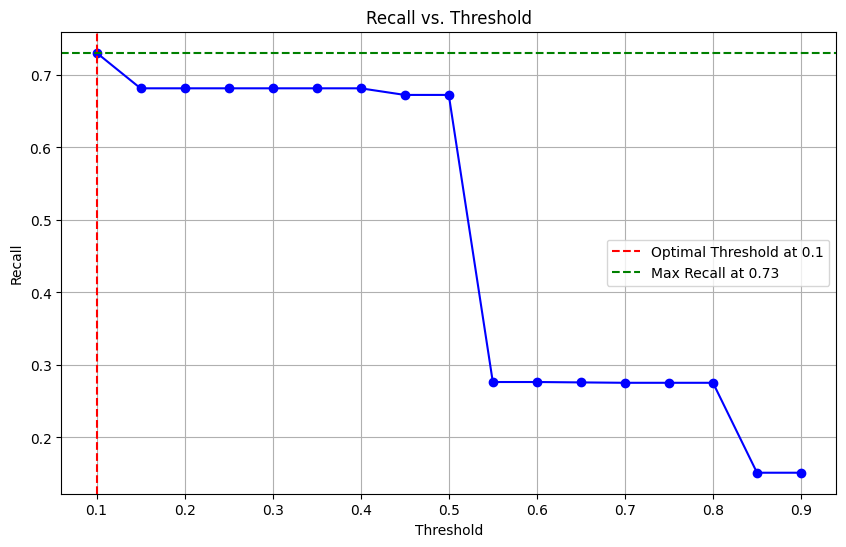

In [51]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, marker='o', linestyle='-', color='b')
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)
plt.axvline(x=0.1, color='r', linestyle='--', label=f'Optimal Threshold at 0.1')
plt.axhline(y=0.7306231537487692, color='g', linestyle='--', label=f'Max Recall at {0.7306231537487692:.2f}')
plt.legend()
plt.show()


PRECISION - RECALL CURVE

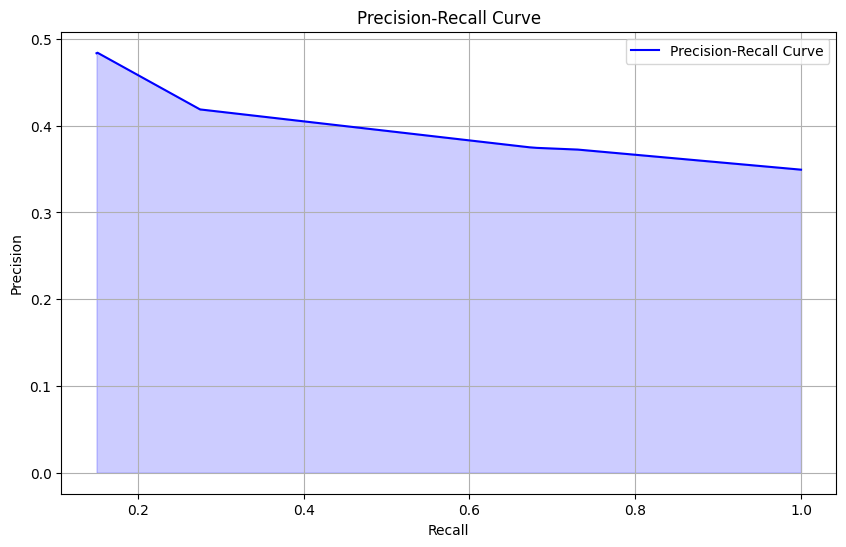

In [52]:
def precision_recall_curve(trees, X, y):
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        predictions = forest_predict(trees, X, threshold=threshold)
        tp = np.sum((predictions == 1) & (y == 1))
        fp = np.sum((predictions == 1) & (y == 0))
        fn = np.sum((predictions == 0) & (y == 1))
        
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    return thresholds, precisions, recalls

# Calculate precision and recall for various thresholds
thresholds_pr, precisions, recalls = precision_recall_curve(forest_balanced, X, y)

# Plotting Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, color='b', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.fill_between(recalls, precisions, alpha=0.2, color='blue')
plt.legend()
plt.show()


CORRELATION MATRIX

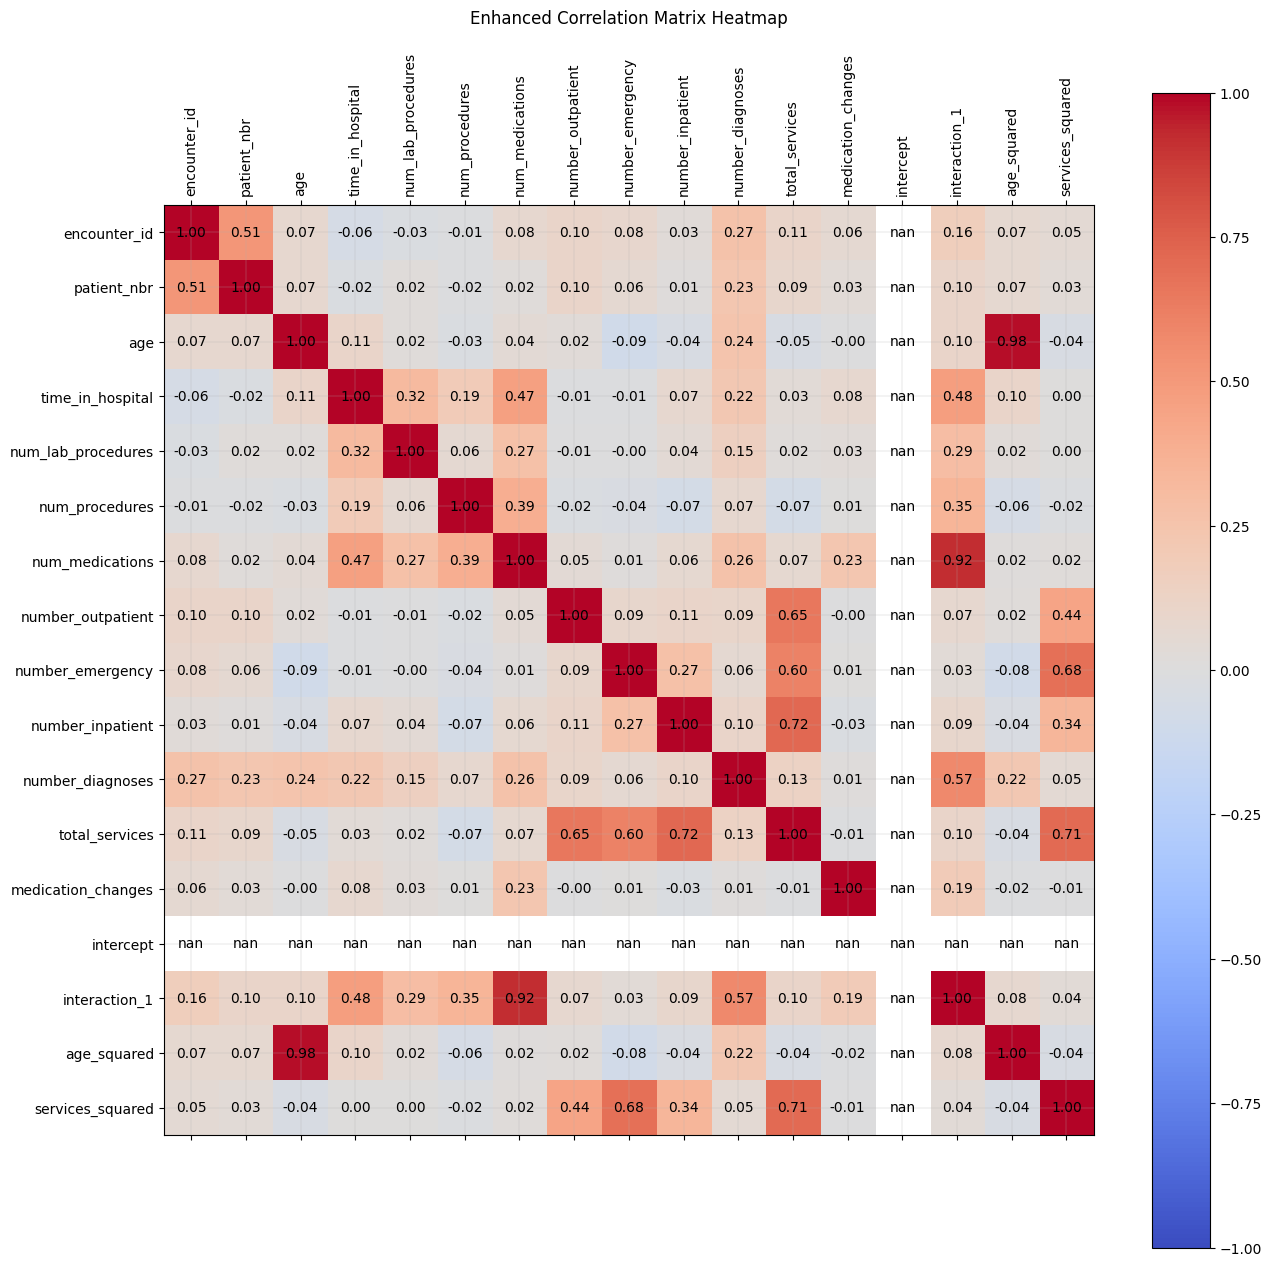

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'correlation_matrix' is a pandas DataFrame containing your correlation data
fig, ax = plt.subplots(figsize=(15, 15))

# Choose a diverging colormap that clearly shows positive and negative correlations
cmap = plt.get_cmap('coolwarm')

# Create the heatmap using the correlation matrix, with our selected colormap
cax = ax.matshow(correlation_matrix, cmap=cmap, vmin=-1, vmax=1)

# Add a color bar to provide a reference
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Adding grid lines for aesthetics
ax.grid(linewidth=0.2)

# Loop over data dimensions and create text annotations.
for (i, j), val in np.ndenumerate(correlation_matrix.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

# Set the title and show the plot
plt.title('Enhanced Correlation Matrix Heatmap', pad=20)
plt.show()


# CONCLUSION FOR THE WORK DONE:
In the end, the project made a tool to predict patient readmissions. This tool can help healthcare providers. It focuses on recall to make sure it predicts patient readmissions well. Two datasets were used to make the tool. It needed careful data work, analysis, perdiction and preprocessing.

In [56]:
def map_user_input_to_feature(race, gender, age, time_in_hospital):
    # Replace the following mapping and averages with the ones from your model
    race_mapping = {'Caucasian': 0, 'AfricanAmerican': 1, 'Other': 2}
    gender_mapping = {'Male': 0, 'Female': 1}
    age_mapping = {'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, 
                   '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}
    
    # Convert inputs to the format expected by the model
    mapped_features = [
        race_mapping.get(race, -1),  # Default to -1 if race not in mapping
        gender_mapping.get(gender, -1),  # Default to -1 if gender not in mapping
        age_mapping.get(age, -1),  # Default to -1 if age not in mapping
        time_in_hospital
        # ... add other features set to their average values or most common values
    ]
    return mapped_features

def user_input_to_features():
    # Collect user input
    race = input("Enter Race (Caucasian/AfricanAmerican/Other): ")
    gender = input("Enter Gender (Male/Female): ")
    age = input("Enter Age Group ([0-10), [10-20), ..., [90-100)): ")
    time_in_hospital = int(input("Enter Time in Hospital (days): "))
    
    # Map user input to feature values
    features = map_user_input_to_feature(race, gender, age, time_in_hospital)
    return features

def predict_readmission(features):
    # This function should load your model and make a prediction
    # For the sake of this example, let's assume it returns a random prediction
    # In practice, you'd replace this with your decision tree's prediction logic
    prediction = predict_tree(trained_decision_tree, features)
    return prediction

def main():
    print("Welcome to the Patient Readmission Prediction Tool.\n")
    
    # Get features from the user
    features = user_input_to_features()
    
    # Predict readmission
    readmission = predict_readmission(features)
    
    # Output the prediction
    if readmission == 1:
        print("\nThe model predicts that the patient WILL be readmitted.")
    else:
        print("\nThe model predicts that the patient WILL NOT be readmitted.")

if __name__ == "__main__":
    main()


Welcome to the Patient Readmission Prediction Tool.

Enter Race (Caucasian/AfricanAmerican/Other): Caucasian
Enter Gender (Male/Female): Female
Enter Age Group ([0-10), [10-20), ..., [90-100)): [10-20)
Enter Time in Hospital (days): 3


NameError: name 'trained_decision_tree' is not defined